# **Import Libraries & Install Packages & Initialize Structures for Preprocessing:**

In [1]:
!pip install demoji
!pip install emoji
!pip install emot
!pip install googletrans==4.0.0-rc1
!pip install Unidecode
!pip install greek-stemmer-pos
!pip install spacy 
!pip install torch
!pip install optuna
!pip install torchmetrics
!pip install transformers
!python -m spacy download el_core_news_sm
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import csv
import torch
import os
import optuna
import spacy
import nltk
import re
import string
import emoji
import demoji
import emot
import itertools
import gensim
import multiprocessing
import numpy as np
import unicodedata as ud
import random
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns
import optuna.visualization as vis
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader,Dataset
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from googletrans import Translator
from emot.emo_unicode import EMOTICONS_EMO
from sklearn.metrics import precision_score, recall_score
from flashtext import KeywordProcessor
from sklearn.linear_model import LogisticRegression
from greek_stemmer import stemmer
from spacy.lang.el.examples import sentences 
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, BertTokenizerFast

nltk.download('stopwords')

  Obtaining dependency information for demoji from https://files.pythonhosted.org/packages/03/66/9dc4b6d57f3a74ad8cf79f0cc4e965165871bfb3f612db77ccd4e0200b38/demoji-1.1.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.3 MB/s eta 0:00:00
  Obtaining dependency information for emot from https://files.pythonhosted.org/packages/28/b3/3a0f1f66c448fc66aba69a73d6405a104fd973142594ee8bc5a5122e949c/emot-3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Obtaining dependency information for httpx==0.13.3 from https://files.pythonhosted.org/packages/54/b4/698b284c6aed4d7c2b4fe3ba5df1fcf6093612423797e76fbb24890dd22f/httpx-0.13.3-py3-none-any.whl.metadata
  Obtaining dependency information for hstspreload from https://files.pythonhosted.org/packages/05/f3/f0c098cce4f5dd11316f1f9cf63fd760320a6c1918741870360039ef6c08/hstspreload-2024.4.1-py3-none-any.wh

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Read the datasets
train_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-3/train_set.csv")
val_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-3/valid_set.csv")

#Concatenate train_df and val_df since they are the only ones that have a label and later split into train,validation and test set
df = pd.concat([train_df, val_df], ignore_index=True)

#Remove rows that don't have acceptable values 
acceptable_labels = ['POSITIVE','NEGATIVE','NEUTRAL']
df = df[df['Sentiment'].isin(acceptable_labels)].reset_index(drop=True)

# **Data Preprocessing & Word Embeddings Using Word2Vec:**

In [3]:
class DataPreprocessing(BaseEstimator, TransformerMixin):
    
    def remove_tags(self, text):
        return re.sub('@.*? ', '',text)
    
    def remove_urls(self, text):
        return re.sub(r'http.?://[^\s]+[\s]?', '',text)
    
    def emoji_to_word(self, text):
        #Get the map of emojis and their meaning in current text
        emojis = demoji.findall(text)
        #Convert the meaning to greek and add pair to keyword processor if it doesn't already exists
        for emoji,value in emojis.items():
            try :
               greek_value = translator.translate(value.replace(":","").replace("_"," ").strip(), src='en', dest='el').text
            except :
                greek_value = ""  
                
            # We replace emojis and emoticons with their corresponding greek words
            kp_emojis.add_keyword(emoji, greek_value) 
            
        return kp_emojis.replace_keywords(text)
    def remove_emoji(self, text):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    
    def remove_hashtags(self,text):
        #We remove the string following the hashtag
        words = text.split()
        return ' '.join(word for word in words if not word.startswith('#'))
    
    def remove_punctuation(self, text):
        # We leave a space in the place of every punctuation symbol to avoid mistaken concatenation between words
        greek_punc = punctuation + '«' +'»'+'’'
        trantab = str.maketrans(greek_punc, len(greek_punc)*' ')  
        return text.translate(trantab)
    
    def remove_accents(self, text):
        d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
        return ud.normalize('NFD',text).translate(d)
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)    
    
    def remove_stopwords(self, text):
        words = text.split() 
        #We remove strings that aren't words as well as stop words
        filtered_words = [word for word in words if (word not in stops) and len(word) > 1] 
        return " ".join(filtered_words) 
    
    def to_lower(self, text):
        return text.lower()
    
    def convert_greeklish(self, text):
        return text.translate(greeklish_to_greek)
    
    def remove_greeklish(self,text):
        # We replace every non-greek word with an empty string
        latin_pattern = r'\b[a-zA-Z]+\b'
        return re.sub(latin_pattern, '', text)
        
    def stemming(self,text):
        words = text.split() 
        stemmed_words = [stemmer.stem_word(word,'VB') for word in words]
        return " ".join(stemmed_words)
    
    def lemmatization(self,text):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc])
    
    def remove_redundant(self,text):
        words = text.split()  
        cleaned_words = []

        for word in words:
            cleaned_word = word.rstrip('ς')  # Remove redundant ς characters from the end of the word
            cleaned_words.append(cleaned_word)

        return  ' '.join(cleaned_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self   
    
    def transform(self, X, **transform_params):
        
        filtered_X = X.apply(self.remove_tags).apply(self.remove_urls)
        
        if 'remove_emojis' in transform_params:
            filtered_X = filtered_X.apply(self.remove_emoji)
        else :
            filtered_X = filtered_X.apply(self.emoji_to_word)
            
        if 'remove_hashtags' in transform_params:
            filtered_X = filtered_X.apply(self.remove_hashtags)            
            
        filtered_X = filtered_X.apply(self.remove_punctuation).apply(self.remove_greeklish)
        
        if 'remove_digits' in transform_params:
            filtered_X = filtered_X.apply(self.remove_digits)
            
        if 'remove_greeklish' in transform_params:
            filtered_X = filtered_X.apply(self.remove_greeklish)   
        else :
            filtered_X = filtered_X.apply(self.convert_greeklish)   
            
        if 'lemmatization'in transform_params:
            filtered_X = filtered_X.apply(self.lemmatization)
            
        elif 'stemming'in transform_params:
            filtered_X = filtered_X.apply(self.stemming)
        
        filtered_X = filtered_X.apply(self.remove_accents).apply(self.to_lower).apply(self.remove_redundant).apply(self.remove_stopwords)
        return filtered_X  
    
    def fit_transform(self, X, **transform_params):
        # Fit phase
        self.fit(X)

        # Transform phase using the provided transform_params
        return self.transform(X, **transform_params)  

In [4]:
#Creating a simple function to roughly convert most greeklish to greek
greek_alphabet = 'ΑαΒβΓγΔδΕεΖζΗηΘθΙιΚκΛλΜμΝνΞξΟοΠπΡρΣσςΤτΥυΦφΧχΨψΩω'
latin_alphabet = 'AaBbGgDdEeZzHhJjIiKkLlMmNnXxOoPpRrSssTtUuFfQqYyWw'
greeklish_to_greek = str.maketrans(latin_alphabet,greek_alphabet)

#Creating a Keyword Processor for converting emojis and emoticons to their greek meaning
translator = Translator()
emoticons = {**EMOTICONS_EMO}
kp_emojis = KeywordProcessor()
#We will create a dictionary that maps each emoticon in each equivalent greek word. We will repeat the same for emojis
for emoticon,value in emoticons.items() :
    try :
       greek_value = translator.translate(value.replace(":","").replace("_"," ").strip(), src='en', dest='el').text
    except :
        greek_value = ""
        
    kp_emojis.add_keyword(emoticon, greek_value)
    
# Load the Greek language model for spacy
nlp = spacy.load('el_core_news_sm')

#More Greek stopwords from our custom made file
with open('/kaggle/input/lowercasegreekstopwords/Greek-Stopwords.txt', 'r') as file:
    # Read lines and remove '\n' from each line
    more_stopwords = [line.strip() for line in file.readlines()]
    
stops = set(stopwords.words('greek')).union(more_stopwords)

# 20 Most Common Words after Text Processing:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'τσιπρα'),
  Text(1, 0, 'μητσοτακη'),
  Text(2, 0, 'νδ'),
  Text(3, 0, 'συριζα'),
  Text(4, 0, 'εκλογε'),
  Text(5, 0, 'κκε'),
  Text(6, 0, 'εκλογες2019'),
  Text(7, 0, '2019'),
  Text(8, 0, 'σκαι'),
  Text(9, 0, 'πασοκ'),
  Text(10, 0, 'κιναλ'),
  Text(11, 0, 'στι'),
  Text(12, 0, 'σα'),
  Text(13, 0, 'κανει'),
  Text(14, 0, 'αλεξη'),
  Text(15, 0, 'νεα'),
  Text(16, 0, 'πω'),
  Text(17, 0, 'ελλαδα'),
  Text(18, 0, 'συνεντευξη'),
  Text(19, 0, 'κυριακο')])

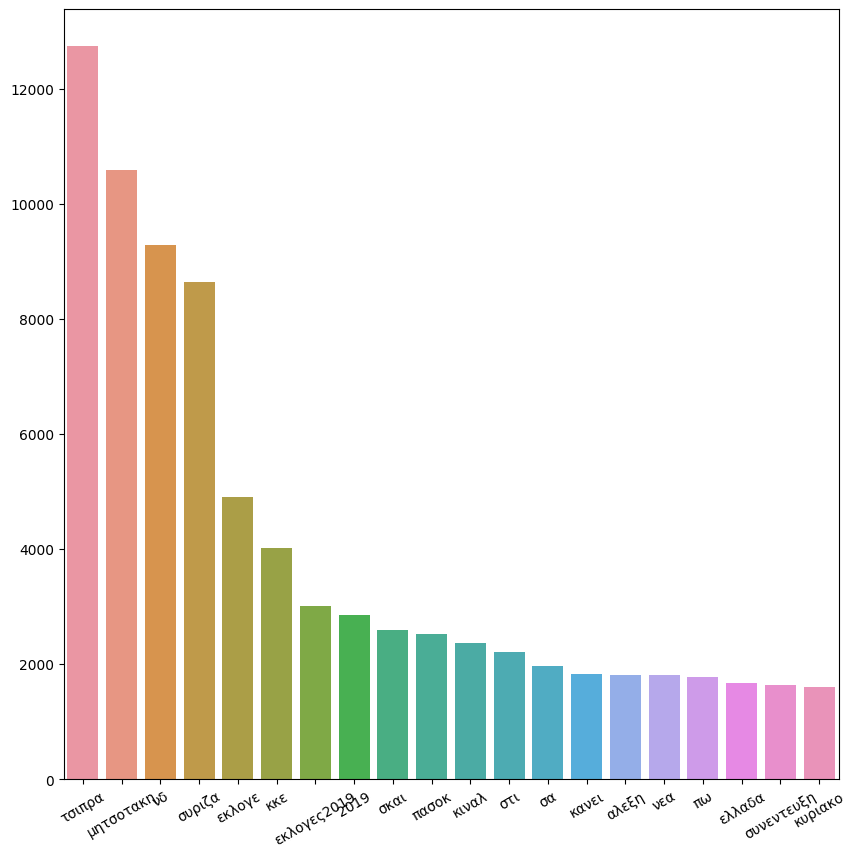

In [5]:
#Data Cleaning
Processor = DataPreprocessing()
params = {'remove_emojis' : 'y'}
df['Text'] = Processor.fit_transform(df['Text'],**params)
#Analysing words' frequency and statistics
words = nltk.tokenize.word_tokenize(df['Text'].str.cat(sep=' '))
word_dist = nltk.FreqDist(words)
most_common = pd.Series(dict(word_dist.most_common(20)))
fig, ax = plt.subplots(figsize=(10,10))
all_plot = sns.barplot(x=most_common.index, y=most_common.values, ax=ax)
plt.xticks(rotation=30)

# **Vectorization:**

In [6]:
def set_seed(seed = 45):

    #For consistency in results we use a deterministic way to control the source of random number generator
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
# Filter out rows with non-zero token count in the 'Text' column
empty_text = df[df['Text'].apply(lambda x: len(x.split()) == 0)].index

# Reset the index to make it consistent after removing rows
df.drop(empty_text, inplace=True)
df.reset_index(drop=True, inplace=True)

labels = df['Sentiment']
final_df = df.drop('Sentiment', axis=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running in ',device)

labels_to_int = {"POSITIVE" : 0, "NEGATIVE" : 1 , "NEUTRAL" : 2}
int_to_labels = {0 : "POSITIVE", 1 : "NEGATIVE", 2 : "NEUTRAL"}
labels = labels.apply(lambda x: labels_to_int.get(x))
labels_tensor = torch.tensor(labels, device=device)

# Load Pretrained Greek Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format('/kaggle/input/greek-pretrained-word2vec/model.txt', binary=False, unicode_errors='replace')

# Build a matrix of weights that will be loaded into the embedding layer.
embed_dim = model.vector_size
tweet_vocab = {}
tweet_vocab = {word: idx for idx, word in enumerate(model.index_to_key)}

Running in  cuda


**Create Datasets & Dataloaders**

In [8]:
class TweetDataset(Dataset):
    def __init__(self, texts, vocab ,labels=None):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.texts_len = [len(text.split()) for text in texts]
        
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx): 
        
        tokens = self.texts[idx].split()
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]         
        
        if self.labels is not None:
            return indices,self.texts_len[idx], self.labels[idx]
        
        return indices, self.texts_len[idx] 

In [9]:
def custom_collate(batch) :
    
    # Sort batch by sequence length in descending order
    batch.sort(key=lambda x: x[1], reverse=True)
    
    inputs = [torch.tensor(item[0]) for item in batch]  # Extract input sequences
    texts_len = [item[1] for item in batch]  # Extract text lengths
    
    # Perform padding on input sequences
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    
    if(len(batch[0]) == 3) :
        targets = [item[2] for item in batch]  # Extract targets
        return padded_inputs,torch.tensor(texts_len),torch.tensor(targets)   
    
    return padded_inputs,torch.tensor(texts_len)

In [10]:
set_seed()

#Splitting into Training (70), Validation & Test Set (15 each)
train_X, remaining_X ,train_Y, remaining_Y = train_test_split(final_df['Text'], labels_tensor, test_size=0.3, random_state=28)
val_X, test_X , val_Y, test_Y = train_test_split(remaining_X, remaining_Y, test_size=0.5, random_state=28)

#Build vocabulary for TweetDataset consisting of the pretrained embeddings and some extra cases
# Define special tokens
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'

tweet_vocab[PAD_TOKEN] = len(tweet_vocab)
tweet_vocab[UNK_TOKEN] = len(tweet_vocab)  
tweet_vocab[SOS_TOKEN] = len(tweet_vocab)  
tweet_vocab[EOS_TOKEN] = len(tweet_vocab)  

In [11]:
train_set = TweetDataset(train_X.values.flatten(), tweet_vocab, train_Y)
train_loader = DataLoader(train_set, batch_size = 32 ,shuffle=False, collate_fn=custom_collate)

val_set = TweetDataset(val_X.values.flatten() ,tweet_vocab ,val_Y)
val_loader = DataLoader(val_set, batch_size = 32 ,shuffle=False, collate_fn=custom_collate)

test_set = TweetDataset(test_X.values.flatten() ,tweet_vocab, test_Y)
test_loader = DataLoader(test_set, batch_size = 32 ,shuffle=False, collate_fn=custom_collate)

#We have 3 classes
output_dim = 3
pad_idx = tweet_vocab[PAD_TOKEN]
vocab_size = len(tweet_vocab)

# **Building the RNN Model**

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self,hidden_size,input_size,cell_type,skip,drop,init_layers=True):
        super(ResidualBlock, self).__init__()
        
        cells = {"LSTM"    : nn.LSTM,
                  "GRU"    : nn.GRU}   
        
        self.cell = cell_type
        self.skip = skip
        
        #Bidirectional RNN layer according to wanted cell type
        self.RnnLayer = cells[cell_type]( input_size,hidden_size, 1, bidirectional=True, dropout=drop, batch_first=True)
        
    def forward(self, x,texts_len):
        
        output = self.RnnLayer(x)
        x_out = output[0]
            
        if self.skip:

            # Unpack the sequences
            tensor1, _ = pad_packed_sequence(x, batch_first=True, padding_value=0)
            tensor2, _ = pad_packed_sequence(x, batch_first=True, padding_value=0)

            # Add along the sequence dimension,(the actual sequence of x is the same as the initial as layers do not affect it somehow)
            x_out_tensor = tensor1 + tensor2
            x = pack_padded_sequence(x_out_tensor,texts_len, batch_first=True,enforce_sorted=False)    

        return x_out

In [13]:
class RNN(nn.Module):
    
  def __init__(self,stacked_num,hidden_size,input_size,cell_type,skip,attention,drop,output_dim,vocab_size,pad_idx):
    super(RNN, self).__init__()
    
    self.attention = attention
    
    #Initializing Embedding Layer with our pretrained embeddings setting embedded padding vector to 0
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = pad_idx)

    #Bidirectional Stacked RNN Residual Blocks
    self.rnn_layers = nn.ModuleList(
                    [ResidualBlock(hidden_size,
                                   2 * hidden_size if i else input_size,
                                   cell_type,
                                   skip if i else False,
                                   drop,device) for i in range(stacked_num)])
    
    #Attention Layer if needed
    if attention :
        #Ensure that number of heads divides embedding dimension,heads being smaller or equal than 10
        divisors = [i for i in range(1, 10) if hidden_size*2 % i == 0]
        self.AttentionLayer = nn.MultiheadAttention(hidden_size * 2,num_heads = max(divisors))    
        self.Linear = nn.Linear(hidden_size*2,hidden_size*2, bias=False)
    
        
    self.dropout = nn.Dropout(drop)
    self.linear =  nn.Linear(hidden_size*2,output_dim)
        
  def forward(self, x,texts_len):
    
    #Pass through Embedding Layer
    x = self.embedding(x)
    
    texts_len = [length for length in texts_len if length > 0]
    
    # Pack padded sequence
    x = pack_padded_sequence(x,texts_len, batch_first=True,enforce_sorted=False)    
    
    # Forward pass through stacked RNN layers
    for layer in self.rnn_layers :
        x = layer(x,texts_len)
      
    # Unpack padded sequence
    x, _ = pad_packed_sequence(x, batch_first=True, padding_value=0)
    
    #Apply Attention Layer if needed
    if self.attention :
        #Query,Key and Value Linear Vectors are identical
        x = self.Linear(x) 
        x,_ = self.AttentionLayer(x,x,x)            
        
    #Apply Linear Layer
    return self.linear(x)

  #Returns the trained model's predictions on loader set
  def predict(self, loader):
    self.eval()
    all_preds = []

    with torch.no_grad():
        for batch in loader:
            X = batch[0].to(device)
            x_len = batch[1]
            pred = self(X,x_len)
            # Accumulate predictions and labels for computing metrics after all batches
            all_preds.extend(torch.max(pred[:, -1, :], dim=-1)[1].cpu().tolist())
    return all_preds

# **Testing**

In [14]:
def evaluation(loader, loss_func, neural):
    neural.eval()
    total_error = 0
    total_correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader : 
            # `batch` contains three pytorch tensors:
            #   [0]: padded sequences  
            #   [1]: sequences' length before padding
            #   [2]: labels             
            X = batch[0].to(device)
            x_len = batch[1]
            label = batch[2].to(device)
            pred = neural(X,x_len).to(device)

            #Prediction is the max value out of the last 3 classes
            total_correct += (torch.max(pred[:, -1, :], dim=-1)[1] == label).sum().item()
            total_error += loss_func(pred[:, -1, :], label).item()

            # Accumulate predictions and labels for computing metrics after all batches
            all_preds.extend(torch.max(pred[:, -1, :], dim=-1)[1].cpu().tolist())
            all_labels.extend(label.cpu().tolist())

    avg_error = total_error / len(loader.dataset)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    accuracy = total_correct / len(loader.dataset) * 100
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_error , f1_macro , accuracy , conf_matrix ,all_preds

# **Training**

In [15]:
#We do validation in every single epoch so it has to be combined in the training function to evaluate the efficiency of current parameters
def train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,neural,patience,clip_value) :

  best_score = -1
  continuous = 0
  train_scores = []
  train_loss = []
  val_scores = []
  val_loss = []   
    
  #Iterate through batches for every epoch
  for epoch in range(epochs) :
    neural.train()   
    #iterating through batches
    for batch in train_loader :      
      # set to zero the parameter gradients
      optimizer.zero_grad()
      # `batch` contains three pytorch tensors:
      #   [0]: padded sequences  
      #   [1]: sequences' length before padding
      #   [2]: labels             
      X = batch[0].to(device)
      x_len = batch[1]
      label = batch[2].to(device)
      pred = neural(X,x_len)
      error = loss_func(pred[:, -1, :],label)
      # computing gradients/the direction that fits our objective
      error.backward()
      #implementing gradient clipping
      torch.nn.utils.clip_grad_norm_(neural.parameters(), clip_value)  
      #optimizing weights/slightly adjusting parameters
      optimizer.step()
    #compute validation scores for each epoch
    loss , f1 , acc , cf_matr  , preds = evaluation(val_loader,loss_func,neural)
    val_scores += [acc]
    val_loss += [loss]
    loss , f1 , acc , cf_matr , preds = evaluation(train_loader,loss_func,neural)
    train_scores += [acc]  
    train_loss += [loss]
    if acc > best_score :
      wanted = neural
      best_score = acc
      best_epoch = epoch
    else :
      continuous += 1
      if continuous == patience :
          return wanted,best_epoch,train_scores,train_loss,val_scores,val_loss
        
  return wanted,best_epoch,train_scores,train_loss,val_scores,val_loss

# **Hyperparmeter Tuning:**

In [16]:
import logging

# Set the logging level to CRITICAL to deactivate messages
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

def objective(trial):
    
    # Define the search space for model's hyperparameters
    epoch = trial.suggest_categorical('epochs', [15,30, 60])
    stacked_num = trial.suggest_int('stacked_num', 2,10)
    hidden_size = trial.suggest_int('hidden_size', 2,256)
    cell = trial.suggest_categorical('cell', ['LSTM','GRU'])
    skip = trial.suggest_categorical('skip', [True, False])    
    clip = trial.suggest_float('clip', 0, 1, step=0.1)                                                                          
    drop = trial.suggest_float('dropout', 0.5, 0.8, step=0.1)    
    attention = trial.suggest_categorical('attention', [True, False])     
    
    #Define the search space for learning hyperparameters
    rate = trial.suggest_categorical('lr', [0.0001,0.001, 0.01, 0.1])
    patience = trial.suggest_categorical('patience', [5, 10,15])

    rnn = RNN(stacked_num,hidden_size,embed_dim,cell,skip,attention,drop,output_dim,vocab_size,pad_idx).to(device)
    optimizer = optim.Adam(rnn.parameters(), lr=rate)
    loss_func = nn.CrossEntropyLoss()
    output = train_and_val(epoch, optimizer, train_loader, val_loader, loss_func,rnn,patience,clip)
    #Compute the test accuracy of the best model (best validation accuracy out of all epochs) on the test set
    loss, f1, acc, cf_matr , preds = evaluation(test_loader, loss_func, output[0])

    return acc  # The accuracy is the metric to be maximized

# **Best Parameters for the Model:**

In [17]:
study = optuna.create_study(direction='maximize')  # maximize accuracy
study.optimize(objective, n_trials=40)# Run optimization for 20 trials

In [18]:
# Print the best hyperparameters and their corresponding accuracy
best_parameters = study.best_params
print("Best parameters ",best_parameters)

rnn = RNN(best_parameters['stacked_num'],
          best_parameters['hidden_size'],
          embed_dim,
          best_parameters['cell'],
          best_parameters['skip'],
          best_parameters['attention'],
          best_parameters['dropout'],
          output_dim,
          vocab_size,
          pad_idx).to(device)

optimizer = optim.Adam(rnn.parameters(), lr=best_parameters['lr'])
loss_func = nn.CrossEntropyLoss()
epochs = best_parameters['epochs']
patience = best_parameters['patience']
clip = best_parameters['clip']
output = train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,rnn,patience,clip)

#Performance of best Model
print("Best epoch is : ",output[1])
loss , f1 , best_accuracy , cf_matr , preds = evaluation(test_loader,loss_func,output[0])
print("F1-score for best model is : ",f1*100 ,", best validation accuracy is ", best_accuracy)

Best parameters  {'epochs': 60, 'stacked_num': 4, 'hidden_size': 209, 'cell': 'GRU', 'skip': True, 'clip': 0.0, 'dropout': 0.7, 'attention': True, 'lr': 0.01, 'patience': 15}
Best epoch is :  0
F1-score for best model is :  16.200353754622927 , best validation accuracy is  32.10132228771706


In [19]:
fig = vis.plot_param_importances(study)
fig.show()

# **Metrics & Plots for Best Model:**

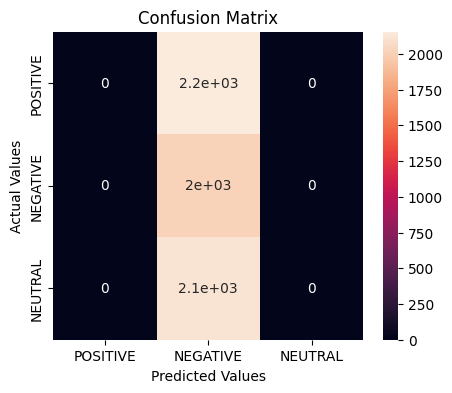

In [20]:
cm_df = pd.DataFrame(cf_matr,
                     index = acceptable_labels, 
                     columns = acceptable_labels)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

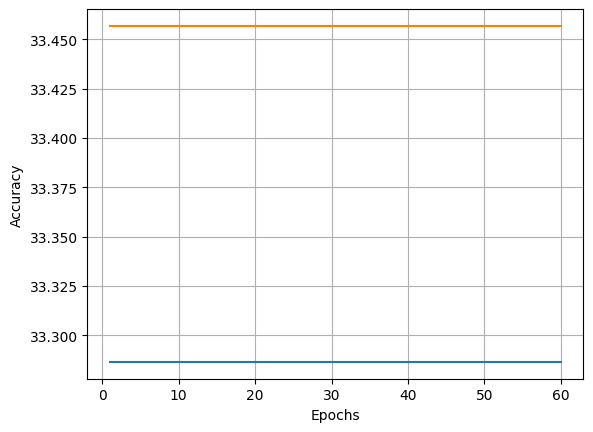

In [21]:
#Plotting Learning Curve
#Splitting into training (80%) & Validation (20%) Set Only this time to get a clearer picture of the performances
train_X, val_X ,train_Y, val_Y = train_test_split(final_df['Text'], labels, test_size=0.2, random_state=28)

train_set = TweetDataset(train_X.values.flatten(),tweet_vocab, train_Y.values.flatten())
train_loader = DataLoader(train_set, batch_size = 32 ,shuffle=False, collate_fn=custom_collate)

val_set = TweetDataset(val_X.values.flatten(),tweet_vocab, val_Y.values.flatten())
val_loader = DataLoader(val_set, batch_size = 32 ,shuffle=False, collate_fn=custom_collate)

#Training again 
rnn = RNN(best_parameters['stacked_num'],
          best_parameters['hidden_size'],
          embed_dim,
          best_parameters['cell'],
          best_parameters['skip'],
          best_parameters['attention'],
          best_parameters['dropout'],
          output_dim,
          vocab_size,
          pad_idx).to(device)

#Train for all epochs
patience = epochs
best_model,best_epoch,train_scores,train_loss,val_scores,val_loss = train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,rnn,patience,clip)

epoch_list = range(1, epochs + 1)
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(epoch_list, train_scores, label="Train Score")
plt.plot(epoch_list, val_scores, label="Validation Score")
plt.show()

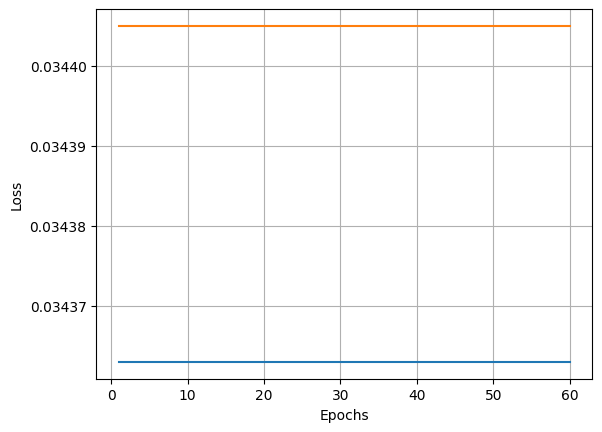

In [22]:
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(epoch_list, train_loss, label="Training Loss")
plt.plot(epoch_list, val_loss, label="Validation Loss")
plt.show()

# **Implementing best model on actual test set:**

In [23]:
#Read Actual Test Set 
test_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-3/test_set.csv")

#Perform best Data Preprocessing Technique 
params = {'remove_emojis' : 'y'}
test_df['Text'] = Processor.fit_transform(test_df['Text'],**params)

# Filter out rows with non-zero token count in the 'Text' column
empty_text = test_df[test_df['Text'].apply(lambda x: len(x.split()) == 0)].index

# Reset the index to make it consistent after removing rows
test_df.drop(empty_text, inplace=True)

#Create Dataset & Dataloader for test_df
test_set = TweetDataset(test_df['Text'].values.flatten(),tweet_vocab)
test_loader = DataLoader(test_set, batch_size = 32 ,shuffle=False, collate_fn=custom_collate)

#Train the model with the entire dataset this time
rnn = RNN(best_parameters['stacked_num'],
          best_parameters['hidden_size'],
          embed_dim,
          best_parameters['cell'],
          best_parameters['skip'],
          best_parameters['attention'],
          best_parameters['dropout'],
          output_dim,
          vocab_size,
          pad_idx).to(device)

patience = best_parameters['patience']
output = train_and_val(epochs,optimizer, train_loader, val_loader, loss_func, rnn,patience,clip)

#Predict using best model
test_pred = output[0].predict(test_loader)

# Create submission.csv output file
with open("submission.csv", "w", newline='') as output_file:
    # Create a CSV writer
    submission = csv.writer(output_file)

    # Write the header row
    submission.writerow(["Id", "Predicted"])

    # Write the data rows
    for idx, predicted_value in zip(test_df['New_ID'], test_pred):
        submission.writerow([idx, int_to_labels[predicted_value]])